# Demo of data cube functionalities: 
# Correlation of S5P L4 Assimilated NO$_2$ with World Settlement Footprint 2019
Here we demonstrate how to correlate Sentinel 5P/TROPOMI-assimilated NO2 data with building heights using EOC data cube functionalities. 

<img src="./building_height_NO2-Case All.drawio.png" />

## Let's start with some relevant settings
<div class="alert alert-block alert-success">
To identify the relevant STAC collection, visit https://geotest.eoc.dlr.de/eoc/ogc/stac/v1/ with your browser.
</div>

### STAC settings

In [1]:
stacapi_endpoint = "https://geoservice.dlr.de/eoc/ogc/stac/v1/?f=application%2Fjson"

In [2]:
bbox = [3.8, 46.82, 15.23, 54.44]

resolution=(0.06,0.09) # 0.06x0.09 deg is the original resolution of TROPOMI L4 Surface NO2 model result

In [3]:
no2_collection_name = ["S5P_TROPOMI_L4_P1D_NO2surf"]
no2_dates_from_to = ["2023-11-21", "2024-07-20"]

In [4]:
wsf_collection_name = ["WSF_2019"]
wsf_dates_from_to = ["2019-01-01", "2019-01-02"]

### Do Python library imports

In [6]:
from pystac_client import Client

from odc.stac import stac_load
from odc.geo  import resxy_
import xarray as xr

In [7]:
import geopandas as gpd

In [8]:
from matplotlib.colors import LinearSegmentedColormap

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [11]:
import numpy

In [12]:
import geopandas
from rasterio import features
from affine import Affine

## Load NO$_2$ Surface Concentrations (derived from S5P TROPOMI)

<div class="alert alert-block alert-success">
Discover and access surface NO$_2$ in its original resolution.</div>

### Discover Dataset

<div class="alert alert-block alert-success">
Connect to STAC API and discover surface NO$_2$ concentrations.</div>

In [13]:
%%time 

catalog = Client.open(
    url=stacapi_endpoint,
    ignore_conformance=True
)

no2_stac_items = catalog.search(
    collections=no2_collection_name, 
    datetime=no2_dates_from_to, 
    bbox=bbox,
    method="GET", 
    filter_lang="cql2-text",
    max_items=1000
).get_all_items()

CPU times: user 142 ms, sys: 8.19 ms, total: 150 ms
Wall time: 8.4 s


In [14]:
print ("Number of STAC items: ", len(no2_stac_items))

Number of STAC items:  179


### Debug Info

In [15]:
for i in range(0, len(no2_stac_items)): print (no2_stac_items.items[i].assets["data"].href)

https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/07/19/S5P_NRT_L4v1_NO2_20240719_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/30/S5P_NRT_L4v1_NO2_20240630_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/29/S5P_NRT_L4v1_NO2_20240629_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/27/S5P_NRT_L4v1_NO2_20240627_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/26/S5P_NRT_L4v1_NO2_20240626_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/25/S5P_NRT_L4v1_NO2_20240625_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/24/S5P_NRT_L4v1_NO2_20240624_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/23/S5P_NRT_L4v1_NO2_20240623_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/22/S5P_NRT_L4v1_NO2_20240622_UTC1500.nc
https://download.geoservice.dlr.de/S5P_TROPOMI/files/L4/2024/06/

In [27]:
no2_stac_items.items[8]

<Item id=S5P_NRT_L4v1_NO2_20231122_UTC1500>

### Access Dataset

<div class="alert alert-block alert-success">
Access surface NO$_2$ concentrations and download dataset in its original resolution to your local memory.</div>

In [16]:
%%time

# ACCESS AND DOWNLOAD IN ORIGINAL RESOLUTION

no2surf = stac_load(
    no2_stac_items,
    crs="EPSG:4326",
    resolution=resxy_(0.09, -0.06), # 0.0174532925199433
    dtype="float",
    lon=(bbox[0], bbox[2]),
    lat=(bbox[1], bbox[3]),)

print ("Data is extracted in its original resolution on the server and downloaded to local storage.")

Data is extracted in its original resolution on the server and downloaded to local storage.
CPU times: user 3.14 s, sys: 9.14 s, total: 12.3 s
Wall time: 11.8 s


In [17]:
# no2surf.attrs["nodata"] = numpy.nan

In [18]:
no2surf

<xarray.Dataset>
Dimensions:      (latitude: 128, longitude: 128, time: 179)
Coordinates:
  * latitude     (latitude) float64 54.45 54.39 54.33 ... 46.95 46.89 46.83
  * longitude    (longitude) float64 3.825 3.915 4.005 ... 15.07 15.16 15.25
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-11-22T15:00:00 ... 2024-07-19T15:...
Data variables:
    no2surf      (time, latitude, longitude) float64 14.94 15.48 ... 1.125

## Do computations (temporal average) of surface NO$_2$

<div class="alert alert-block alert-success">
Temporal Average Over Complete Period.</div>

In [19]:
no2surf["average"] = no2surf.no2surf.mean(dim="time")

## Show temporal average of NO$_2$ surface concentration

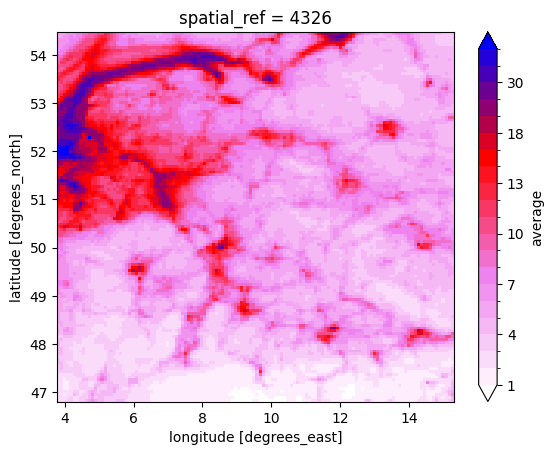

In [20]:
no2surf.average.plot(
    levels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,18,20,25,30,35,40], 
    cmap=LinearSegmentedColormap.from_list("", ["white", "violet", "red","blue"]))

## Load Global Urban Footprint (WSF 2019) in identical spatial resolution

<div class="alert alert-block alert-success">
The World Settlement Footprint (WSF) 2019 is a 10m resolution binary mask outlining the extent of human settlements globally derived by means of 2019 multitemporal Sentinel-1 (S1) and Sentinel-2 (S2) imagery. (see https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/WSF_2019)
</div>

### Data Discovery

In [21]:
wsf_stac_items = catalog.search(
    collections=wsf_collection_name, 
    datetime=wsf_dates_from_to, 
    bbox=bbox,
    method="GET", 
    filter_lang="cql2-text",
    max_items=1000
).get_all_items()

In [22]:
wsf_stac_items

### Data Access

<div class="alert alert-block alert-success">
Now the data of the identifed data sets is going to be downloaded to the local client.

You can concentrate on your work. All ugly work such as 
- re-projection or
- area-slicing 
 
is done on the server.</div>

In [55]:
%%time

wsf_data = stac_load(
    wsf_stac_items,
    crs="EPSG:4326",
    resolution=resxy_(0.09, -0.06), # 0.0174532925199433
    resampling="average",
    dtype="float",
    lon=(bbox[0], bbox[2]),
    lat=(bbox[1], bbox[3]),)

CPU times: user 381 ms, sys: 316 ms, total: 697 ms
Wall time: 523 ms


In [56]:
wsf_data

<xarray.Dataset>
Dimensions:      (latitude: 128, longitude: 128, time: 1)
Coordinates:
  * latitude     (latitude) float64 54.45 54.39 54.33 ... 46.95 46.89 46.83
  * longitude    (longitude) float64 3.825 3.915 4.005 ... 15.07 15.16 15.25
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-07-02T11:59:59
Data variables:
    wsf2019      (time, latitude, longitude) float64 nan nan nan ... 1.988 10.18

### Show World Settlement Footprint 2019

Text(0.5, 1.0, 'WSF 2019 [%]')

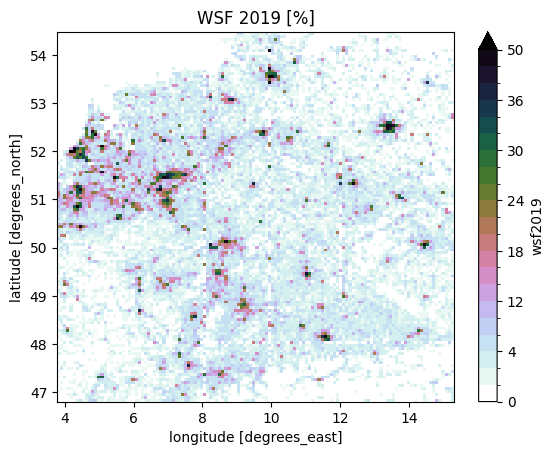

In [66]:
(wsf_data.wsf2019[0,:,:]/2.55).plot(
    levels = [0,1,2,4,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,50], 
    cmap = "cubehelix_r")
plt.title ("WSF 2019 [%]")

## Correlate World Settlement Footprint 2019 with NO2_surf

In [35]:
no2surf_1D = no2surf.average.values.flatten()
wsf2019_1D = wsf_data.wsf2019.values.ravel()

In [38]:
x = numpy.zeros((0), dtype=float)
y = numpy.zeros((0), dtype=float)

for i in range(wsf2019_1D.shape[0]):
    if (0 < wsf2019_1D[i]) and (0 < no2surf_1D[i] and no2surf_1D[i] <= 80):
        x = numpy.append(x, no2surf_1D[i])
        y = numpy.append(y, wsf2019_1D[i]/2.55)
        
xy = numpy.vstack([x,y])

intensity = gaussian_kde(xy)(xy)

## Show Correlation of GUF 2019 and NO2_surf (Zoomed into the graph)

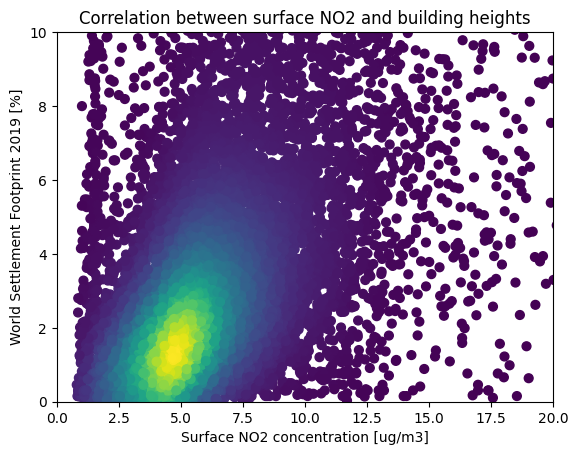

In [41]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=intensity, s=40)
ax.set_title("Correlation between surface NO2 and building heights")
ax.set_ylabel("World Settlement Footprint 2019 [%]")
ax.set_xlabel("Surface NO2 concentration [ug/m3]")
ax.set_xlim(0,20)
ax.set_ylim(0,10)
plt.show()

## Show Correlation of GUF 2019 and NO2_surf

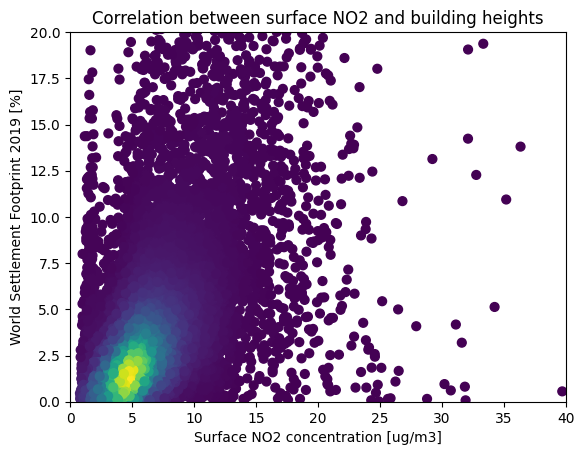

In [42]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=intensity, s=40)
ax.set_title("Correlation between surface NO2 and building heights")
ax.set_ylabel("World Settlement Footprint 2019 [%]")
ax.set_xlabel("Surface NO2 concentration [ug/m3]")
ax.set_xlim(0,40)
ax.set_ylim(0,20)
plt.show()